In [11]:
import numpy as np

step = np.linspace(0,10000,10000)

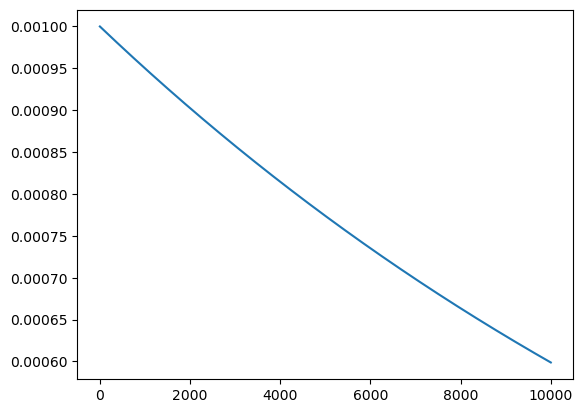

In [13]:
import matplotlib.pyplot as plt
lr = 0.001 * 0.95 **(step/1000)

plt.figure()
plt.plot(step,lr)
plt.show()